In [5]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

C:\Users\Asus\anaconda\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Asus\anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

[nltk_data] Downloading package reuters to E:\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


C:\Users\Asus\anaconda\lib\site-packages\sklearn\decomposition\online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


# CO-OCCURENCE


In [6]:
def read_corpus(category="gold"):
    
    files = reuters.fileids(category)
    
    return [ [START_TOKEN] + [w.lower() for w in reuters.words(f)] + [END_TOKEN] for f in files]

In [7]:
corpus = read_corpus()

In [8]:
pprint.pprint(corpus[0],width=100,compact = True)

['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
 'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
 'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
 'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the', 'mine',
 ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned', '60',
 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace', 'and',
 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east', 'of',
 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a', 'statement',
 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional', 'leach',
 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000', 'ounces',
 'of', 'gold', 'in', 'it

# task 1

In [9]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    ### SOLUTION BEGIN
    
    for s in corpus:
        for w in s:
            if not w in corpus_words:
                corpus_words.append(w)
    
    corpus_words.sort()
    
    n_corpus_words = len(corpus_words)
    
    ### SOLUTION END

    return corpus_words, n_corpus_words

In [10]:

test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words,num_corpus_words = distinct_words(test_corpus)


ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)


In [11]:
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# task 2

In [12]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    ### SOLUTION BEGIN
    
    for i in range(n_words):
        
        word2ind[words[i]] = i
    
    M = np.zeros((n_words,n_words))
    
    n = window_size
    
    for word in words:
        
        idx = word2ind[word]
        
        for s in corpus:
            
            for i in range(len(s)):
                
                if s[i] == word:
                    
                    
                    left = max(0,i-window_size)
                    right = min(len(s)-1,i+window_size)
                        
                    for j in range(left,right+1):
                        if j==i:
                            continue
                        M[idx][word2ind[s[j]]] +=1

    ### SOLUTION END

    return M, word2ind

In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# task 3

In [14]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    ### SOLUTION BEGIN
        
        
    svd =  TruncatedSVD(n_components=k, n_iter=n_iters)
        
    M_reduced = svd.fit_transform(M)
        
        
        
    ### SOLUTION END

    print("Done.")
    return M_reduced

In [15]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [16]:
M_test_reduced

array([[ 6.54802087e-01,  7.83221122e-01],
       [ 5.20200324e-01, -1.50802812e-15],
       [ 7.05647176e-01, -4.84057274e-01],
       [ 7.05647176e-01,  4.84057274e-01],
       [ 1.02780472e+00,  7.39242571e-16],
       [ 6.54802087e-01, -7.83221122e-01],
       [ 3.82258491e-01, -6.56224003e-01],
       [ 3.82258491e-01,  6.56224003e-01],
       [ 1.39420808e+00,  1.06179274e+00],
       [ 1.39420808e+00, -1.06179274e+00]])

# task 4

In [17]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    ### SOLUTION BEGIN
    idx = [M_reduced[word2ind[w]] for w in words ]
    
    X = [x[0] for x in idx]
    Y = [y[1] for y in idx]
    
    plt.figure(figsize=(10,5))
    
    for word in words:
        
        plt.text(M_reduced[word2ind[word]][0],M_reduced[word2ind[word]][1],word)
        
        
    
    plt.scatter(X,Y,marker='x',color='red')
    plt.xlabel("first principal component")
    plt.ylabel("second principal component")

    plt.show()
    ### SOLUTION END

--------------------------------------------------------------------------------
Outputted Plot:


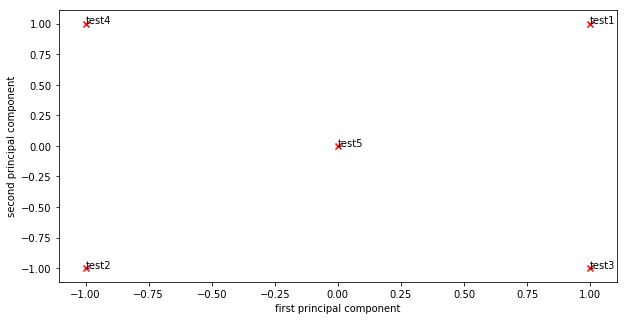

--------------------------------------------------------------------------------


In [18]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test , word2ind_plot_test, words)

print ("-" * 80)

# task 5

Running Truncated SVD over 2830 words...
Done.


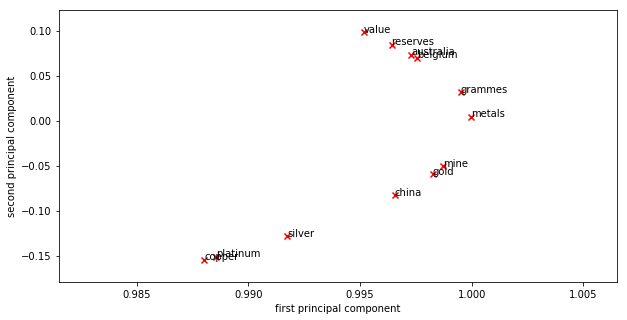

In [19]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

# part 2

In [2]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [3]:
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [20]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [21]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


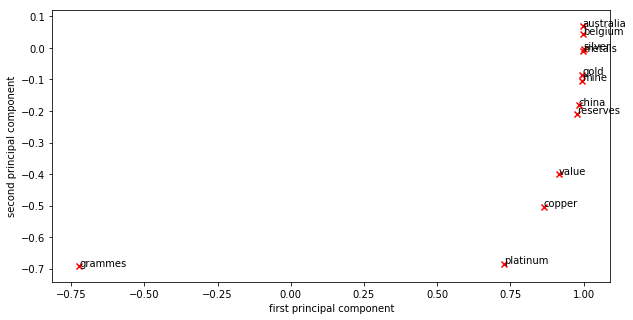

In [54]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_reduced_normalized, word2ind, words)

In [43]:
wv_from_bin.most_similar("fall")

[('falling', 0.7143270969390869),
 ('drop', 0.7129500508308411),
 ('beginning', 0.7102552056312561),
 ('rise', 0.7045484185218811),
 ('decline', 0.694981575012207),
 ('year', 0.6926088929176331),
 ('coming', 0.684209942817688),
 ('months', 0.6710376143455505),
 ('come', 0.6675800085067749),
 ('may', 0.661205530166626)]

In [44]:
### SOLUTION BEGIN

w1 = "block"
w2 = "allow"
w3 = "stop"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

### SOLUTION END

Synonyms block, allow have cosine distance: 0.5110869705677032
Antonyms block, stop have cosine distance: 0.5173312723636627


In [45]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608444690704346),
 ('granddaughter', 0.7200807332992554),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005681991577148),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767380714417),
 ('grandparents', 0.6446608901023865),
 ('wife', 0.644535481929779)]


In [59]:
### SOLUTION BEGIN

x, y, a, b = "wife","husband","hen","rooster"
wv_from_bin.most_similar(positive=[a, y], negative=[x])
#assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

### SOLUTION END

[('hendee', 0.5000368356704712),
 ('hens', 0.46696844696998596),
 ('coel', 0.44073203206062317),
 ('henze', 0.4265890121459961),
 ('cock', 0.4042142927646637),
 ('ogledd', 0.4026843309402466),
 ('wlad', 0.39380866289138794),
 ('rooster', 0.389360249042511),
 ('vipheak', 0.387412965297699),
 ('chel', 0.3776510953903198)]

In [60]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922031760215759),
 ('15,000-square', 0.4649604260921478),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.4441334009170532),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.43563973903656006),
 ('3,000-square', 0.4348650872707367),
 ('30,000-square', 0.4330596625804901),
 ('footed', 0.43236875534057617)]


In [64]:
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'doctor'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'engineer'], negative=['man']))

[('dr.', 0.548629641532898),
 ('physician', 0.5327187776565552),
 ('he', 0.5275284647941589),
 ('him', 0.5230658054351807),
 ('himself', 0.5116502642631531),
 ('medical', 0.5046804547309875),
 ('his', 0.5044265985488892),
 ('brother', 0.503484845161438),
 ('surgeon', 0.5005415678024292),
 ('mr.', 0.4938008189201355)]

[('technician', 0.5853331089019775),
 ('engineers', 0.5717717409133911),
 ('educator', 0.5450620055198669),
 ('engineering', 0.48699602484703064),
 ('contractor', 0.4856792390346527),
 ('nurse', 0.48517879843711853),
 ('schoolteacher', 0.4825061857700348),
 ('teacher', 0.47406384348869324),
 ('mechanic', 0.4704253673553467),
 ('married', 0.4676802158355713)]


In [67]:
### SOLUTION BEGIN

A = "man"
B = "woman"
word = "pink"
pprint.pprint(wv_from_bin.most_similar(positive=[A, word], negative=[B]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[B, word], negative=[A]))

### SOLUTION END

[('yellow', 0.6758068799972534),
 ('red', 0.6238754391670227),
 ('blue', 0.6092661619186401),
 ('purple', 0.5785847306251526),
 ('green', 0.5396619439125061),
 ('gray', 0.5309217572212219),
 ('colored', 0.5288407206535339),
 ('shirt', 0.520612895488739),
 ('dark', 0.519768476486206),
 ('bright', 0.5098283886909485)]

[('satin', 0.5685141086578369),
 ('fuchsia', 0.5632011294364929),
 ('lavender', 0.5587139129638672),
 ('purple', 0.5524871945381165),
 ('dress', 0.5486237406730652),
 ('dresses', 0.5456576943397522),
 ('colored', 0.53913813829422),
 ('blouse', 0.5252315402030945),
 ('turquoise', 0.5235313177108765),
 ('violet', 0.5226369500160217)]
